# ACR Phantom Resolution Measuements

Based on spot groups.

## Analysis Resolution spots

In [1]:
import numpy as np
import pandas as pd
from mriqa.dcmio import fetch_series
from mriqa.tools import show_mosaic
from mriqa.phantoms import phantom_mask_2d, find_phantom
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import zoom

from skimage.feature import match_template, register_translation

from mriqa.dcmio import (
    rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx, number_of_frames
)

from mriqa.tools import rectangular_roi_coords

import matplotlib.pyplot as plt
import seaborn as sns

The resolution objects are groups of spots

Matrix (ZYX): [72, 512, 512]
Voxel Dimensions (ZYX): [2.0, 0.48828125, 0.48828125]


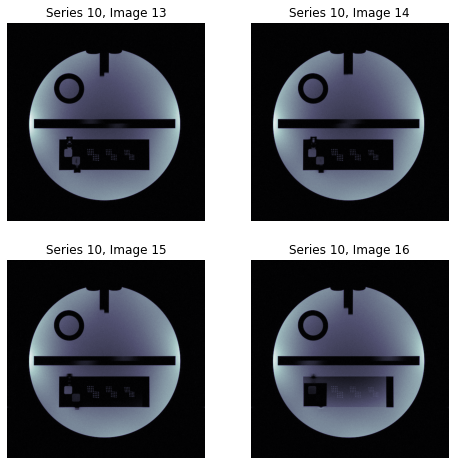

In [2]:
# ACR scan 2mm slice SE for orientation
patid = 'PQACRY20160411RHD'
stuid = '1'
sernos = [10]
dobjs = fetch_series(patid, stuid, sernos)

images = [d.pixel_array & 0x0fff for d in dobjs]
pix_dims = np.asarray(dobjs[0].PixelSpacing)
assert np.isclose(*pix_dims)

nslices =  len(dobjs)
slice_spacing = abs(np.diff(sorted(d.SliceLocation for d in dobjs)).mean())

print('Matrix (ZYX):', [len(images)] + list(images[0].shape))
print('Voxel Dimensions (ZYX):', [slice_spacing] + list(pix_dims))

show_mosaic(dobjs[12:16], cmap='bone')

We'll pick the single slice where the two slice profile plates most closely coincide. This seems to be in the plane of the spots as well.

Interpolation Factor: 2
New Matrix [1024, 1024]
New Voxel Dimensions [0.244140625, 0.244140625]
Image Min/Max 0 65535
Centre = [504, 527] , Radius = 391


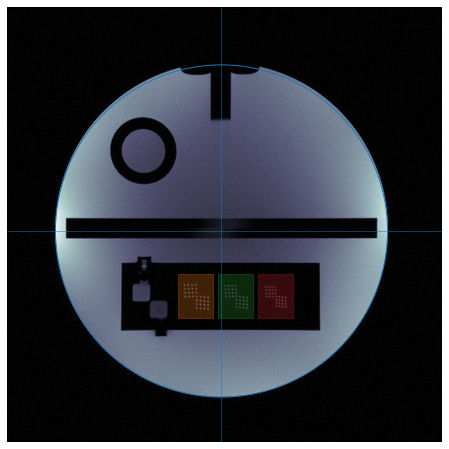

In [3]:
best_slice = 14
dobj = dobjs[best_slice-1]

pix_dims = pix_spacing_yx(dobj)
assert np.isclose(*pix_dims)

interpolation_factor = 2

image = rescale_intensity(zoom(dobj.pixel_array & 0x0fff, interpolation_factor))
pix_dims = tuple(d / interpolation_factor for d in pix_dims)

print('Interpolation Factor:', interpolation_factor)
print('New Matrix', list(image.shape))
print('New Voxel Dimensions', list(pix_dims))
print('Image Min/Max', image.min(), image.max())

ACRRES = {
    'Name': 'ACRRES',
    'Diameter': 190,  # mm
    'PD': 1.0,
    'T1': 500.0, # TODO: estimate from 10mM Ni2+ 
    'T2': 500.0,
    'Features': {
        'Spots': [
            ((-25, 25), (20, 25)),
            ((-2, 25), (20, 25)),
            ((21, 25), (20, 25))
        ],       
    }
}

expected_radius = ACRRES['Diameter'] / 2 / pix_dims[0]
centre_x, centre_y, radius = find_phantom(image, expected_radius=expected_radius)

print('Centre =', [centre_x, centre_y], ', Radius =', radius)

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='bone')
plt.axis('off')
plt.grid(False)
nrows, ncols = image.shape

plt.axvline(centre_x, linewidth=0.5, color='C0')
plt.axhline(centre_y, linewidth=0.5, color='C0')
plt.gcf().gca().add_artist(
    plt.Circle((centre_x, centre_y), radius, color='C0', fill=False)
)

spotgroups = ACRRES['Features']['Spots']
for spotgroup, colour in zip(spotgroups, ['C1', 'C2', 'C3']):
    x, y, dx, dy = rectangular_roi_coords(pix_dims, rect=spotgroup, centre=(centre_x, centre_y))
    plt.gca().add_artist(plt.Rectangle([x, y], dx, dy, color=colour, alpha=0.25))


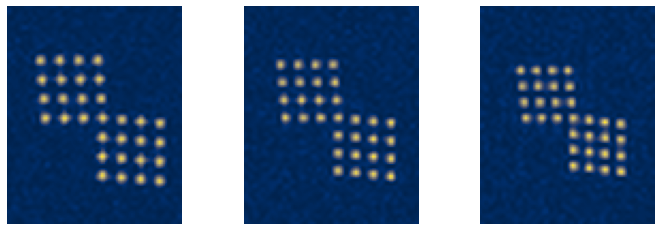

In [4]:
boxes = [rectangular_roi_coords(pix_dims, rect=spotgroup, centre=(centre_x, centre_y)) for spotgroup in spotgroups]
rois = [image[y:y+dy, x:x+dx] for x, y, dx, dy in boxes]

fig, axs = plt.subplots(1, len(rois), figsize=(4*len(rois), 4))
for roi, ax in zip(rois, axs):
    ax.imshow(roi, cmap='cividis')
    ax.axis('off')
    

These are so well resolved in this small pixel size image it's a bit difficult to know what to say.